In [14]:
from sklearn.model_selection import cross_val_score, GroupKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import shap
import pickle
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr



In [2]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

In [3]:
file_path = "../../Exp_2_Dataset_feature_engineering/Summary_and_dataset/PCA_dataset_ExpMP.csv"

data = pd.read_csv(file_path)
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [4]:
overlapping_values = set(train['Drug-solvent system']).intersection(test['Drug-solvent system'])
overlapping_values

set()

In [5]:
def data_processing (dataset):

    X = dataset.drop(['Type', 'Drug', 'Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)'], axis = 1)
    Y = dataset['LogS']
    G = dataset['Drug-solvent system']

    return X, Y, G

In [6]:
X_train, Y_train, G_train = data_processing(train)
X_test, Y_test, G_test = data_processing(test)
X_lab, Y_lab, G_lab = data_processing(lab)

In [7]:
X_train.shape

(19896, 85)

# Hyperparameter screening

In [8]:
search_spaces = {
    "DT": {
        "max_depth": Integer(3, 20),
        "splitter":Categorical(['best', 'random']),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
    },
    "RF": {
        "n_estimators": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
        "bootstrap": Categorical([True, False]),
    },
    "XGB": {
        "n_estimators": Integer(10, 400),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "max_depth": Integer(3, 20),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0),
        "gamma": Real(0, 5),
    },
    "NN": {
        "hidden_layer_sizes": Integer(2, 64),
        "alpha": Real(0.0001, 0.1, prior="log-uniform"),
        "learning_rate_init": Real(0.001, 0.1, prior="log-uniform"),
        "activation": Categorical(['relu', 'tanh', 'logistic']),
},

    "LightGBM": {
        "num_leaves": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "n_estimators": Integer(100, 1000),
        "bagging_fraction": Real(0.5, 1),
        "feature_fraction": Real(0.5, 1),
        "min_child_samples": Integer(5, 100),
    },
    "MLR": {
        'fit_intercept':Categorical([True, False]),
        'positive':Categorical([True, False])
    },
    "Lasso": {
        "alpha": Real(0.0001, 1, prior="log-uniform"),
        "selection": Categorical(['cyclic', 'random']),
    },
    "kNN": {'n_neighbors':Integer(2, 50),
            'weights': Categorical(["uniform", 'distance']),
            'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': Integer(10, 100),
            'p':Integer(1, 2),
    },
    "PLS": {'n_components':Integer(2, 6),
            'max_iter': Integer(250, 1000)
    }
    
}


In [9]:
models = {
    "DT": DecisionTreeRegressor(random_state=0),
    "RF": RandomForestRegressor(random_state=0, n_jobs=6),
    "XGB": XGBRegressor(random_state=0, n_jobs=6),
    "NN": MLPRegressor(random_state=0),
    "LightGBM": lgb.LGBMRegressor(random_state=0, n_jobs=6),
    "MLR": LinearRegression(),
    "Lasso": Lasso(),
    "PLS": PLSRegression(),
    "kNN": KNeighborsRegressor(n_jobs=6)}

In [11]:
def perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter):

    
    model = models[model_name]
    search_space = search_spaces[model_name]
    
    cv = GroupKFold(n_splits=10)

    
    bscv = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_iter=n_iter,
        n_jobs=6,
        verbose=0,
        random_state = 0
    )

    
    bscv.fit(X_train, Y_train, groups=G_train)

    
    return bscv.best_estimator_, bscv.best_params_, bscv.best_score_


In [12]:
model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]
results = {}

n_iter = 100


In [13]:
for model_name in model_names:
    
    
    search_space = search_spaces[model_name]
    best_model, best_params, best_score = perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter)
    
    
    print(model_name, ':  ', round(best_score,3))
    
    # Storing the results in a dictionary
    results[model_name] = {
        'best_estimator': best_model,
        'best_params': best_params,
        'best_score': best_score
    }

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.


DT :   -0.753


/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packag

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

RF :   -0.618


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


XGB :   -0.538
NN :   -0.413
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsa

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5289489218467651
[LightGBM] [Warning] bagging_fraction is set=0.7643458710377254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7643458710377254
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.5289489218467651, colsample_bytree=1.0 will be ignored

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.8380397544384568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8380397544384568
[LightGBM] [Warning] bagging_fraction is set=0.7654820824760737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7654820824760737
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9894518292131809
[LightGBM] [Warning] bagging_fraction is set=0.629185830986374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.629185830986374
[LightGBM] [Warning] feature_fraction is set=0.9894518292131809, colsample_bytree=1.0 will be ignor

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9559574687336727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559574687336727
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6104710605650874, subsample=1.0 will be ignored. Current value: bagging_frac

[LightGBM] [Warning] bagging_fraction is set=0.6104710605650874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6104710605650874
[LightGBM] [Warning] feature_fraction is set=0.5398002567654789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5398002567654789
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5398002567654789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5398002567654789
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.6236164374428196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6236164374428196
[LightGBM] [Warning] bagging_fraction is set=0.8091450537237079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091450537237079
[LightGBM]

[LightGBM] [Warning] bagging_fraction is set=0.8091450537237079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8091450537237079
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[Light

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
LightGBM :   -0.509


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

MLR :   -0.559
Lasso :   -0.541


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

PLS :   -0.512


The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

kNN :   -0.426


In [10]:
pickle_file_path = 'Results/PCA_BSCV_results.pkl'

In [15]:

with open(pickle_file_path, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:

with open(pickle_file_path, 'rb') as handle:
    results = pickle.load(handle)

Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or 

In [12]:
results

{'DT': {'best_estimator': DecisionTreeRegressor(max_depth=14, max_features='auto', min_samples_leaf=2,
                        min_samples_split=0.036508594913104174, random_state=0,
                        splitter='random'),
  'best_params': OrderedDict([('max_depth', 14),
               ('max_features', 'auto'),
               ('min_samples_leaf', 2),
               ('min_samples_split', 0.036508594913104174),
               ('splitter', 'random')]),
  'best_score': -0.7527636595364373},
 'RF': {'best_estimator': RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                        min_samples_split=0.01, n_estimators=329, n_jobs=6,
                        random_state=0),
  'best_params': OrderedDict([('bootstrap', False),
               ('max_depth', 20),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 1),
               ('min_samples_split', 0.01),
               ('n_estimators', 329)]),
  'best_score': -0.61773095899934},


# Model evaluation using the literature test set

In [15]:
model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "Lasso", "PLS", "kNN"]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = ['MAE', 'MedAE', 'RMSE', 'MSE', 'PCC', 'SCC']
train_summary = pd.DataFrame(index=metrics, columns=model_names)
test_summary = pd.DataFrame(index=metrics, columns=model_names)
predictions = pd.DataFrame(columns=model_names)

for model_name in model_names:
    model = results[model_name]['best_estimator']

    cv = GroupKFold(n_splits=10)
    Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv, groups=G_train, n_jobs=6)

    Y_train = np.ravel(Y_train)
    Y_pred_train = np.ravel(Y_pred_train)
    
    train_summary[model_name]['MAE'] = mean_absolute_error(Y_train, Y_pred_train)
    train_summary[model_name]['MedAE'] = np.median(abs(Y_train - Y_pred_train))
    train_summary[model_name]['RMSE'] = rmse(Y_train, Y_pred_train)
    train_summary[model_name]['MSE'] = mean_squared_error(Y_train, Y_pred_train)
    train_summary[model_name]['PCC'] = pearsonr(Y_train, Y_pred_train)[0]
    train_summary[model_name]['SCC'] = spearmanr(Y_train, Y_pred_train)[0]



    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    
    Y_pred_test = np.ravel(Y_pred_test)
    
    test_summary[model_name]['MAE'] = mean_absolute_error(Y_test, Y_pred_test)
    test_summary[model_name]['MedAE'] = np.median(abs(Y_test - Y_pred_test))
    test_summary[model_name]['RMSE'] = rmse(Y_test, Y_pred_test)
    test_summary[model_name]['MSE'] = mean_squared_error(Y_test, Y_pred_test)
    test_summary[model_name]['PCC'] = pearsonr(Y_test, Y_pred_test)[0]
    test_summary[model_name]['SCC'] = spearmanr(Y_test, Y_pred_test)[0]
    
    predictions[model_name] = Y_pred_test

/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fractio

In [16]:
train_summary

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.752667,0.617663,0.537819,0.413195,0.509178,0.540651,0.512041,0.426044
MedAE,0.605596,0.523207,0.418539,0.298093,0.404127,0.412666,0.401041,0.245195
RMSE,0.97374,0.773448,0.709187,0.590895,0.661249,0.734232,0.668151,0.671928
MSE,0.948169,0.598221,0.502946,0.349157,0.43725,0.539096,0.446426,0.451488
PCC,0.470536,0.764266,0.732693,0.829585,0.779988,0.718182,0.770175,0.784951
SCC,0.442295,0.720475,0.698217,0.825129,0.742067,0.717085,0.739747,0.751764


In [17]:
test_summary

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.797542,0.629708,0.532537,0.420031,0.526737,0.506231,0.51138,0.448468
MedAE,0.635066,0.5315,0.426256,0.286503,0.398907,0.395491,0.407862,0.288275
RMSE,1.03695,0.797496,0.690523,0.600202,0.691208,0.698168,0.698582,0.691375
MSE,1.075265,0.636,0.476821,0.360242,0.477768,0.487438,0.488017,0.478
PCC,0.460269,0.758397,0.772726,0.830495,0.779858,0.760096,0.760173,0.782033
SCC,0.369367,0.738967,0.753435,0.800033,0.759355,0.755623,0.749984,0.731197


In [18]:
test_AE = predictions.copy()

test_AE['Y'] = Y_test.values

for model_name in model_names:
    test_AE[model_name] = abs(test_AE[model_name] - test_AE['Y'])
    
test_AE = test_AE.drop(['Y'], axis = 1)    
test_AE

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
0,0.042102,0.058298,0.008341,0.015540,0.073866,0.144167,0.124079,0.748825
1,0.291668,0.708989,0.575325,0.349027,0.434569,0.552908,0.556816,0.309513
2,0.031192,0.704929,0.553044,0.248178,0.611920,0.422756,0.334369,0.992780
3,0.037572,0.749579,0.552232,0.324042,0.592492,0.379758,0.278340,0.983484
4,0.317284,0.499736,0.224402,0.026953,0.454489,0.483294,0.427266,0.921555
...,...,...,...,...,...,...,...,...
6805,0.586368,0.664329,1.105206,0.206875,0.410164,0.232794,0.329509,0.149301
6806,0.276603,0.793898,1.035835,0.105308,0.505400,0.273850,0.357535,0.162940
6807,0.171065,0.904782,1.109484,0.093304,0.564606,0.267625,0.338280,0.152614
6808,0.011618,0.130593,0.634070,0.680096,0.011341,0.118432,0.004343,0.032873


In [19]:
for column in train_summary.columns:
    train_summary[column] = train_summary[column].astype(float)
    test_summary[column] = test_summary[column].astype(float)

In [20]:
train_summary_round = train_summary.round(3)
test_summary_round = test_summary.round(3)

In [21]:
train_summary_round

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.753,0.618,0.538,0.413,0.509,0.541,0.512,0.426
MedAE,0.606,0.523,0.419,0.298,0.404,0.413,0.401,0.245
RMSE,0.974,0.773,0.709,0.591,0.661,0.734,0.668,0.672
MSE,0.948,0.598,0.503,0.349,0.437,0.539,0.446,0.451
PCC,0.471,0.764,0.733,0.830,0.780,0.718,0.770,0.785
SCC,0.442,0.720,0.698,0.825,0.742,0.717,0.740,0.752


In [22]:
test_summary_round

,DT,RF,XGB,NN,LightGBM,Lasso,PLS,kNN
MAE,0.798,0.630,0.533,0.420,0.527,0.506,0.511,0.448
MedAE,0.635,0.532,0.426,0.287,0.399,0.395,0.408,0.288
RMSE,1.037,0.797,0.691,0.600,0.691,0.698,0.699,0.691
MSE,1.075,0.636,0.477,0.360,0.478,0.487,0.488,0.478
PCC,0.460,0.758,0.773,0.830,0.780,0.760,0.760,0.782
SCC,0.369,0.739,0.753,0.800,0.759,0.756,0.750,0.731


In [23]:
test_summary_round_T = test_summary_round.T
test_summary_round_T

,MAE,MedAE,RMSE,MSE,PCC,SCC
DT,0.798,0.635,1.037,1.075,0.460,0.369
RF,0.630,0.532,0.797,0.636,0.758,0.739
XGB,0.533,0.426,0.691,0.477,0.773,0.753
NN,0.420,0.287,0.600,0.360,0.830,0.800
LightGBM,0.527,0.399,0.691,0.478,0.780,0.759
Lasso,0.506,0.395,0.698,0.487,0.760,0.756
PLS,0.511,0.408,0.699,0.488,0.760,0.750
kNN,0.448,0.288,0.691,0.478,0.782,0.731


In [24]:
sorted_models_ind = test_summary_round_T.sort_values(by="MAE", ascending=True).index
sorted_models = test_summary_round_T.loc[sorted_models_ind]
sorted_models



,MAE,MedAE,RMSE,MSE,PCC,SCC
NN,0.420,0.287,0.600,0.360,0.830,0.800
kNN,0.448,0.288,0.691,0.478,0.782,0.731
Lasso,0.506,0.395,0.698,0.487,0.760,0.756
PLS,0.511,0.408,0.699,0.488,0.760,0.750
LightGBM,0.527,0.399,0.691,0.478,0.780,0.759
XGB,0.533,0.426,0.691,0.477,0.773,0.753
RF,0.630,0.532,0.797,0.636,0.758,0.739
DT,0.798,0.635,1.037,1.075,0.460,0.369


In [25]:
test_AE = test_AE[sorted_models_ind]
test_AE

,NN,kNN,Lasso,PLS,LightGBM,XGB,RF,DT
0,0.015540,0.748825,0.144167,0.124079,0.073866,0.008341,0.058298,0.042102
1,0.349027,0.309513,0.552908,0.556816,0.434569,0.575325,0.708989,0.291668
2,0.248178,0.992780,0.422756,0.334369,0.611920,0.553044,0.704929,0.031192
3,0.324042,0.983484,0.379758,0.278340,0.592492,0.552232,0.749579,0.037572
4,0.026953,0.921555,0.483294,0.427266,0.454489,0.224402,0.499736,0.317284
...,...,...,...,...,...,...,...,...
6805,0.206875,0.149301,0.232794,0.329509,0.410164,1.105206,0.664329,0.586368
6806,0.105308,0.162940,0.273850,0.357535,0.505400,1.035835,0.793898,0.276603
6807,0.093304,0.152614,0.267625,0.338280,0.564606,1.109484,0.904782,0.171065
6808,0.680096,0.032873,0.118432,0.004343,0.011341,0.634070,0.130593,0.011618


In [26]:
test_summary_round = test_summary_round[sorted_models_ind]
test_summary_round.to_excel('Figure_3b.xlsx', index = True)
test_summary_round

,NN,kNN,Lasso,PLS,LightGBM,XGB,RF,DT
MAE,0.420,0.448,0.506,0.511,0.527,0.533,0.630,0.798
MedAE,0.287,0.288,0.395,0.408,0.399,0.426,0.532,0.635
RMSE,0.600,0.691,0.698,0.699,0.691,0.691,0.797,1.037
MSE,0.360,0.478,0.487,0.488,0.478,0.477,0.636,1.075
PCC,0.830,0.782,0.760,0.760,0.780,0.773,0.758,0.460
SCC,0.800,0.731,0.756,0.750,0.759,0.753,0.739,0.369


In [27]:
train_summary_round = train_summary_round[sorted_models_ind]
train_summary_round.to_excel('Figure_SI_training_results.xlsx', index = True)
train_summary_round

,NN,kNN,Lasso,PLS,LightGBM,XGB,RF,DT
MAE,0.413,0.426,0.541,0.512,0.509,0.538,0.618,0.753
MedAE,0.298,0.245,0.413,0.401,0.404,0.419,0.523,0.606
RMSE,0.591,0.672,0.734,0.668,0.661,0.709,0.773,0.974
MSE,0.349,0.451,0.539,0.446,0.437,0.503,0.598,0.948
PCC,0.830,0.785,0.718,0.770,0.780,0.733,0.764,0.471
SCC,0.825,0.752,0.717,0.740,0.742,0.698,0.720,0.442


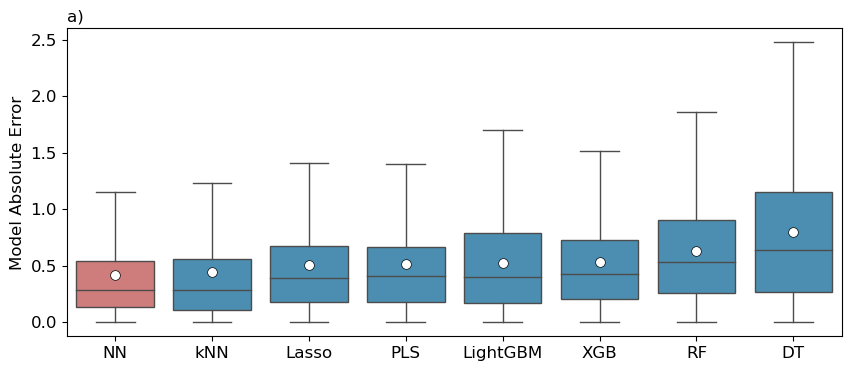

In [30]:

plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})


palette = [red] + [blue] * (len(test_AE.columns) - 1)


sns.boxplot(data=test_AE, palette=palette, showfliers=False, showmeans=True,linewidth = 1.0, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize": 7, "markeredgewidth": 0.5, "markeredgecolor": "black"})


        
plt.title('')
plt.ylabel('Model Absolute Error')

plt.annotate('a)', xy=(0, 1.06), xycoords="axes fraction", va="top", ha="left", fontsize=12)
plt.savefig('Figure_SI_PCA_Model_test_boxplots.png', transparent=True, dpi=300)